In [1]:
import wave as wave
import numpy as np
import scipy.signal as sg
import matplotlib.pyplot as plt
from pathlib import Path


def calc_array_manifold_vector(mic_alignments, theta, n_mic, n_bin, fs, N, c):
    # ysinΘ + xcosΘ
    """
    a: i x n_mic x 1 x n_bin
       方向数 x マイク数 x 1 x 周波数ビン数
    """
    rc = 0.0365
    mic_angle = np.array(
        [
            0,
            np.pi / 4,
            np.pi / 2,
            np.pi * 3 / 4,
            np.pi,
            np.pi * (5 / 4),
            np.pi * (3 / 2),
            np.pi * (7 / 4),
        ]
    )
    a = np.zeros((theta.shape[0], n_mic, 1, n_bin), dtype=np.complex64)
    for i, th in enumerate(theta):
        th = np.radians(th)
        for k in range(n_bin):
            fk = fs * k / N
            for m in range(n_mic):
                delay = -rc * np.cos(th - mic_angle[m]) / c
                a[i, m, 0, k] = np.exp(-1j * 2 * np.pi * fk * delay)
    return a


def load_onefile(file_name):
    """
    return M x frames ndarray
    """
    wav = wave.open(file_name)
    print("sample width:", wav.getsampwidth())
    print("channel num:", wav.getnchannels())
    print("frames:", wav.getnframes())

    M = wav.getnchannels()

    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data / np.iinfo(np.int16).max

    multi_data = data.reshape(-1, M)
    multi_data = np.transpose(multi_data)
    print("multi_data.shape:", multi_data.shape)

    wav.close()

    return multi_data

sample width: 2
channel num: 8
frames: 480192
multi_data.shape: (8, 480192)
[9.52349666e-09 9.63294333e-09 9.73630154e-09 9.83317339e-09
 9.92329774e-09 1.00065467e-08 1.00829549e-08 1.01527187e-08
 1.02161657e-08 1.02737747e-08 1.03261186e-08 1.03738609e-08
 1.04177111e-08 1.04584066e-08 1.04966595e-08 1.05331388e-08
 1.05684324e-08 1.06030411e-08 1.06373506e-08 1.06716636e-08
 1.07062190e-08 1.07412426e-08 1.07770113e-08 1.08138796e-08
 1.08523164e-08 1.08929017e-08 1.09362537e-08 1.09829932e-08
 1.10336966e-08 1.10888339e-08 1.11487743e-08 1.12137677e-08
 1.12839755e-08 1.13594592e-08 1.14402159e-08 1.15261756e-08
 1.16171863e-08 1.17130776e-08 1.18135963e-08 1.19184449e-08
 1.20272841e-08 1.21397150e-08 1.22552972e-08 1.23735493e-08
 1.24939499e-08 1.26159634e-08 1.27390161e-08 1.28625430e-08
 1.29859599e-08 1.31087017e-08 1.32302409e-08 1.33500588e-08
 1.34676901e-08 1.35827110e-08 1.36947609e-08 1.38035414e-08
 1.39087986e-08 1.40103555e-08 1.41080978e-08 1.42019623e-08
 1.429194

Text(0.5, 0, 'Time[frame]')

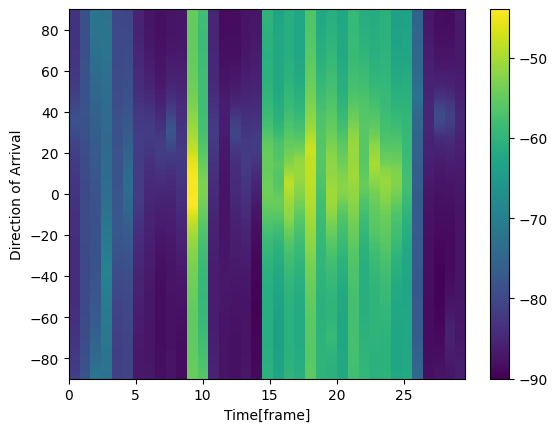

In [5]:
body = "step_front0_200_0"

dir_name = str(Path.cwd().parent)
file_name = "/step_corner_datas/" + body + ".wav"
file_name = dir_name + file_name

# パラメータ
png_name = body + "_MUSIC.png"  # 出力するグラフの画像名
n_mic = 8  # マイクの数
n_src = 3  # 音源の数
N = 512  # 窓の大きさ
window = "hann"  # 窓の種類
d = 0.01  # マイクの間隔[m]
c = 340  # 音速[m/s]
freq_l = 800  # 空間スペクトルを計算する周波数の下限
freq_h = 3000  # 空間スペクトルを計算する周波数の下限

mic_alignments = np.array(
    [
        [0.0, 0.0365, 0.0],
        [0.0258, 0.0258, 0.0],
        [0.0365, 0.0, 0.0],
        [0.0258, -0.02580, 0.0],
        [0.0, -0.0365, 0.0],
        [-0.0258, -0.0258, 0.0],
        [-0.0365, 0.0, 0.0],
        [-0.0258, 0.0258, 0.0],
    ]
)

fs = 16000

# 周波数ビンに変換
k_l = int(freq_l / (fs / N))
k_h = int(freq_h / (fs / N))


audio = load_onefile(file_name)

# 短時間フーリエ変換(STFT)を行う X.shape=(n_mic, n_bin, n_frame)
f, t, X = sg.stft(audio, fs, window=window, nperseg=N)
n_bin = X.shape[1]

t_array = t[::50]

frame_set = 50
set_num = 1

theta = np.linspace(-90.0, 90.0, 181)
P_MU = np.zeros((X.shape[2] // 50, theta.shape[0]))
a = calc_array_manifold_vector(mic_alignments, theta, n_mic, n_bin, fs, N, c)

while set_num * frame_set < X.shape[2]:
    X_trimed = X[:, :, (set_num - 1) * frame_set : set_num * frame_set]
    # 空間相関行列を求める
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3)

    # 固有値を求めて大きい順に並べる
    eig_val = np.zeros((n_mic, n_bin), dtype=np.complex64)
    eig_vec = np.zeros((n_mic, n_mic, n_bin), dtype=np.complex64)
    beta = np.zeros(n_bin)
    for k in range(n_bin):
        eig_val_k, eig_vec_k = np.linalg.eig(R[:, :, k])  # 固有値、固有ベクトルを求める
        sort = np.argsort(-1.0 * np.abs(eig_val_k))  # 大きい順にargsort
        eig_val[:, k] = eig_val_k[sort]  # 固有値を大きい順に並べる
        eig_vec[:, :, k] = eig_vec_k[:, sort]  # 固有ベクトルも並べ替える

    W = eig_vec[:, n_src:, :]  # 音源の数より大きい番号の固有ベクトル
    beta = np.sum(np.abs(eig_val[:n_src, :]), axis=0)  # 重みβを求める

    # 空間スペクトル作成
    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHa = np.einsum("mik,mjk->ijk", aH, a[i])
        P_MU_th = np.einsum("mik,mek->iek", aH, W)
        P_MU_th = np.einsum("iek,jek->ijk", P_MU_th, np.conjugate(P_MU_th))
        P_MU_th = np.abs(aHa) / np.abs(P_MU_th)
        P_MU[set_num - 1][i] = np.mean(
            beta[k_l : k_h + 1] * P_MU_th[0, 0, k_l : k_h + 1]
        )

    if set_num == 5 or set_num == 20:
        print(P_MU[set_num - 1])

    # # グラフを出力
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(theta, 10*np.log10(P_MU[set_num-1]), c="red")
    # ax.set_xlim([-90,90])
    # ax.set_xlabel("Direction [deg]")
    # ax.set_ylabel("Spatial spectrum [dB]")
    # # fig.savefig(png_name)

    set_num = set_num + 1

P_MU = 10 * np.log10(P_MU)
P_MU = P_MU.transpose()
# color_min = np.min(P_MU)
color_min = -90
color_max = np.max(P_MU)
plt.imshow(
    P_MU,
    interpolation="nearest",
    aspect="auto",
    extent=[t_array.min(), t_array.max(), -90, 90],
    vmin=color_min,
    vmax=color_max,
)
plt.colorbar()
plt.ylabel("Direction of Arrival")
plt.xlabel("Time[frame]")

# # 候補を出力
# index=sg.argrelmax(P_MU) # ピークのあるインデックスを求める
# sort=np.argsort(-1.0*P_MU[index])   # ピークの中でargsort
# for i in range(n_src):
#     print(theta[index[0][sort[i]]]) # 大きい順に方向を表示